<a href="https://colab.research.google.com/github/dannynacker/roX_gen/blob/main/roX_omni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following notebook contains two scripts.

Both scripts produce plots of each session as well as .txt files that are formatted to be read by the device, featuring one oscillator utilizing all 4 LEDs.

The first script generates 5 separate sessions based on different resonance dynamics. Each time the script is ran, these sessions will be produced slightly differently, unless a seed is specified.

All sessions generated remain within the parameters set by WP1. These parameters include:

**Luminance:** 10-100 %

**Frequency:** 3-15 Hz

**Duty Cycle:** 25-75 %

Restraints in the intensity of parameter shifts are also put in place per WP1:

**Luminance Shifts:** No more than 20% at a time

**Frequency Shifts:** No greater than 2.2x at a time

**Duty Cycle Shifts:** No more than 25% at a time

However, these restraints correspond to the granularity of this sequence generator -- 100 ms steps -- which may not perfectly reflect the capacity of shift intensity explored by WP1.

Each of the 5 sessions is built using different resonance logic.

**1. HG (Harmonic Glide)**

Frequency increases linearly across our range, with slight noise. Luminance and duty cycle modulate sinusoidally over time for smooth changes. In short, frequency rises over time, with rhythmic changes in luminance and duty cycle.

**2. OM (Ocillatory Mode) **

Frequency oscillates around 9 Hz, but with +- 3 Hz periodic shifts. Luminance and duty cycle modulate sinuosidally, but at a faster rate than in HG. In short, all parameters remain cyclic and structured throughout the session.

**3. DP (Divergent Pattern) **

Frequency is modulated by small multiplicative patterns around the previous value, ensuring all values remain relative to each other over time. Luminance and duty cycle, however, feature randomized jumps, increasing unpredictability. In short, while structured in some aspects, this session is also semi-random.  

**4. CP (Chirped Excitation)**

Frequency accelerates rapidly (like a chirp). Luminance and duty cycle gradually increase according to a power-law curve. In short, this session ramps up over time, with exponential growth across the session.

**5. RE (Randomized Exploration)**

All parameters are randomized at each step while remaining within the set range.

The second script takes a designated 60 seconds from each generated session in a specified order and appends them into an "omni-session" in which the specific characteristics of each generation logic can be more directly compared to each other to aid in further fine-tuning of session parameters.



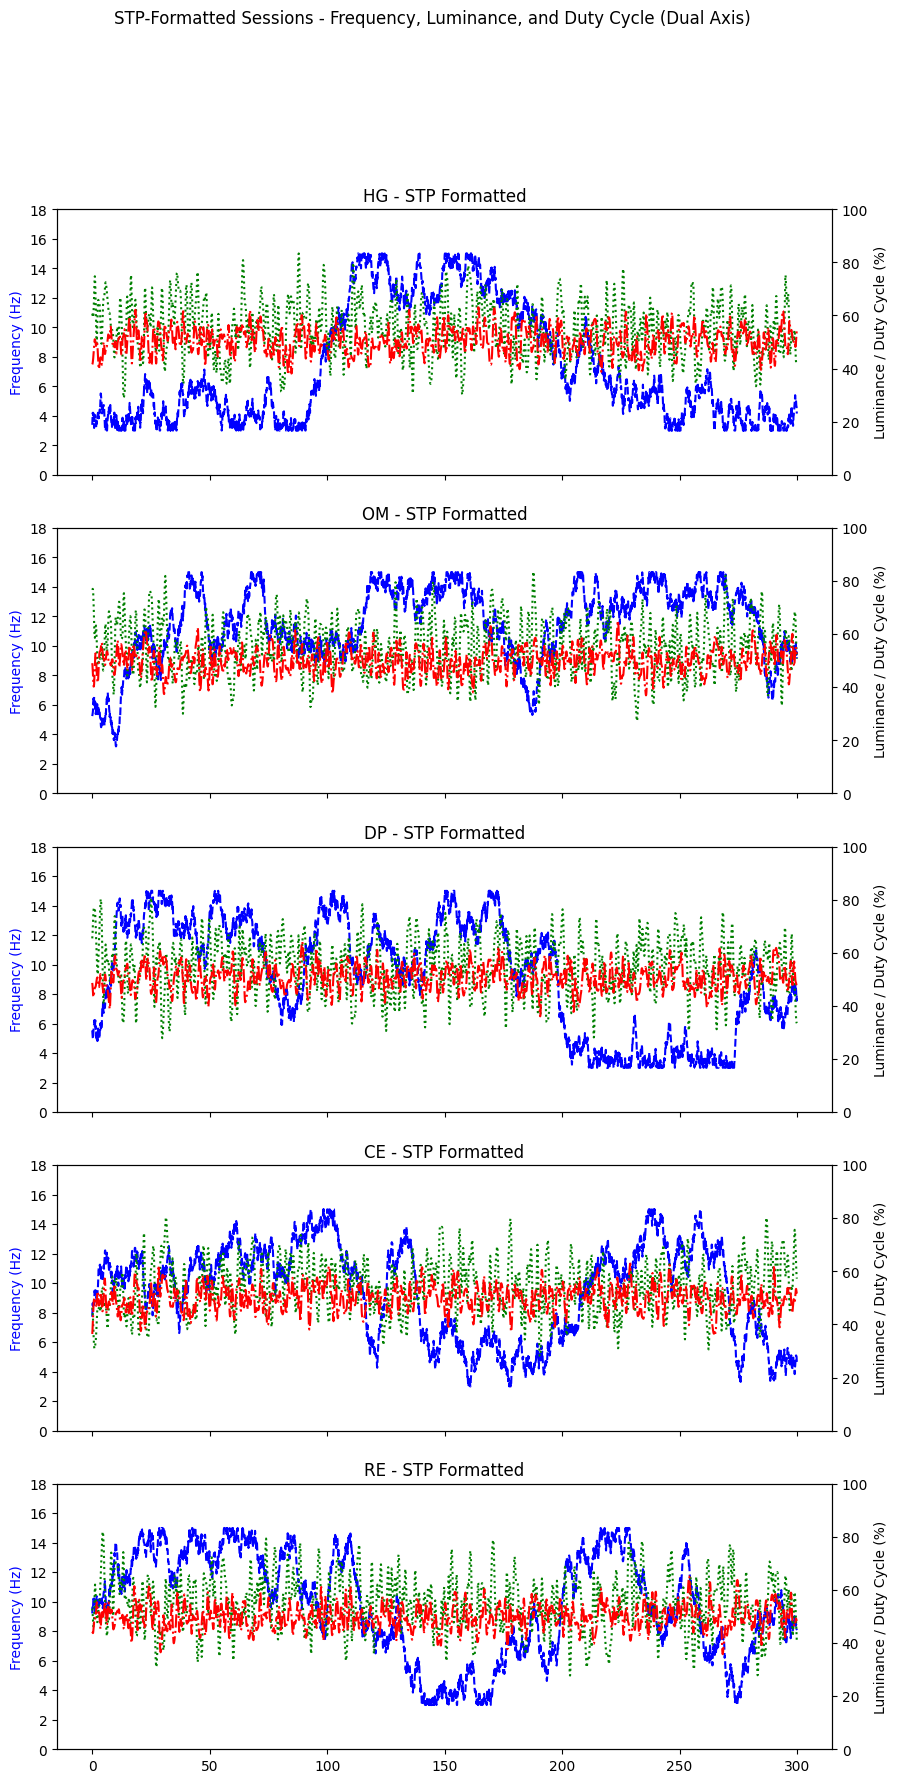

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ===========================
# Session Parameters
# ===========================
session_duration = 300  # 5 minutes (300 seconds)
time_step = 0.1  # 0.1s resolution
num_steps = int(session_duration / time_step)

# Parameter constraints
frequency_range = (3, 15)  # Hz
luminance_range = (10, 100)  # Arbitrary units
duty_cycle_range = (25, 75)  # Percentage
max_duty_jump = 25  # Max duty cycle change per step
max_luminance_jump = 20  # Max luminance change per step
max_freq_jump = 1.2  # Constrain frequency changes but allow variation
smoothing_sigma = 3  # Smoothing factor for luminance & duty cycle

# ===========================
# Directory Setup
# ===========================
output_dir = "session_data"
stp_dir = "stp_sessions"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(stp_dir, exist_ok=True)

# ===========================
# Modulation Functions
# ===========================

def modulate_frequency(prev_freq, progress, mode):
    """Generate frequency variation dynamically based on mode."""
    if mode == "harmonic_glide":
        freq = 3 + (12 * progress) + np.random.uniform(-0.5, 0.5)
    elif mode == "oscillatory_mode":
        freq = 9 + 3 * np.sin(2 * np.pi * progress) + np.random.uniform(-0.2, 0.2)
    elif mode == "divergent_pattern":
        freq = prev_freq * (1 + np.random.uniform(-0.1, 0.1))
    elif mode == "chirped_excitation":
        freq = 3 + (10 * (progress ** 1.5)) + np.random.uniform(-0.3, 0.3)
    elif mode == "randomized_exploration":
        freq = np.random.uniform(*frequency_range)
    else:
        freq = prev_freq + np.random.uniform(-0.5, 0.5)

    freq = np.clip(freq, prev_freq / max_freq_jump, prev_freq * max_freq_jump)
    freq = np.clip(freq, *frequency_range)
    return freq

def modulate_luminance(progress, prev_lum, mode):
    """Generate luminance variation while following constraints (integer values)."""
    if mode == "harmonic_glide":
        target = 10 + (90 * np.sin(progress * np.pi))
    elif mode == "oscillatory_mode":
        target = 10 + (90 * (0.5 + 0.5 * np.sin(4 * np.pi * progress)))
    elif mode == "divergent_pattern":
        target = np.random.randint(10, 101) if np.random.rand() < 0.5 else prev_lum
    elif mode == "chirped_excitation":
        target = 10 + (90 * (progress ** 1.2))
    elif mode == "randomized_exploration":
        target = np.random.randint(10, 101)
    else:
        target = np.random.randint(10, 101)

    return int(np.clip(prev_lum + np.clip(target - prev_lum, -max_luminance_jump, max_luminance_jump), *luminance_range))

def modulate_duty_cycle(progress, prev_duty, mode):
    """Generate duty cycle variation while following constraints (integer values)."""
    if mode == "harmonic_glide":
        target = 25 + (50 * np.sin(progress * np.pi))
    elif mode == "oscillatory_mode":
        target = 25 + (50 * (0.5 + 0.5 * np.sin(6 * np.pi * progress)))
    elif mode == "divergent_pattern":
        target = np.random.randint(25, 76) if np.random.rand() < 0.5 else prev_duty
    elif mode == "chirped_excitation":
        target = 25 + (50 * (progress ** 1.3))
    elif mode == "randomized_exploration":
        target = np.random.randint(25, 76)
    else:
        target = np.random.randint(25, 76)

    return int(np.clip(prev_duty + np.clip(target - prev_duty, -max_duty_jump, max_duty_jump), *duty_cycle_range))

# ===========================
# Generate Sessions
# ===========================

def generate_sequence(mode):
    time = np.arange(0, session_duration, time_step)
    frequency = np.zeros(num_steps)
    luminance = np.zeros(num_steps)
    duty_cycle = np.zeros(num_steps)

    frequency[0] = np.random.uniform(*frequency_range)
    luminance[0] = np.random.uniform(*luminance_range)
    duty_cycle[0] = np.random.uniform(*duty_cycle_range)

    for i in range(1, num_steps):
        progress = i / num_steps
        frequency[i] = modulate_frequency(frequency[i - 1], progress, mode)
        luminance[i] = modulate_luminance(progress, luminance[i - 1], mode)
        duty_cycle[i] = modulate_duty_cycle(progress, duty_cycle[i - 1], mode)

    luminance = gaussian_filter1d(luminance, sigma=smoothing_sigma)
    duty_cycle = gaussian_filter1d(duty_cycle, sigma=smoothing_sigma)

    return pd.DataFrame({
        "Time (s)": time,
        "Frequency (Hz)": frequency,
        "Luminance": luminance,
        "Duty Cycle (%)": duty_cycle
    })

session_types = ["HG", "OM", "DP", "CE", "RE"]
base_sequences = {name: generate_sequence(name.lower()) for name in session_types}

# ===========================
# Convert to STP Format & Save as .txt
# ===========================

def format_strobe_sequence(df, wave_type):
    """Formats DataFrame into STP format with correct interpolation & wave type."""
    output = []
    output.append(f'TIM"00:00:{session_duration:.1f}"')
    output.append(f'DUR"{session_duration:.1f}"')

    for i in range(len(df) - 1):
        stp_line = f'STP"{time_step:.1f},{wave_type},{df.loc[i, "Frequency (Hz)"]:.2f},{df.loc[i+1, "Frequency (Hz)"]:.2f},{df.loc[i, "Duty Cycle (%)"]},{df.loc[i+1, "Duty Cycle (%)"]},1,1,1,1,{df.loc[i, "Luminance"]},{df.loc[i+1, "Luminance"]}"'
        output.append(stp_line)

    return "\r\n".join(output)

for mode, df in base_sequences.items():
    wave_type = 1 if "Sq" in mode else 2  # 1 = Square, 2 = Sine
    strobe_data = format_strobe_sequence(df, wave_type)
    with open(f"{stp_dir}/{mode}.txt", "w", encoding="utf-8") as f:
        f.write(strobe_data)

# ===========================
# Updated Plotting Code
# ===========================

fig, axes = plt.subplots(len(session_types), 1, figsize=(10, 20), sharex=True)

for ax, (mode, df) in zip(axes, base_sequences.items()):
    ax2 = ax.twinx()
    ax.plot(df["Time (s)"], df["Frequency (Hz)"], linestyle="dashed", color="blue", label="Frequency (Hz)")
    ax.set_ylim(0, 18)
    ax2.plot(df["Time (s)"], df["Luminance"], linestyle="dotted", color="green", label="Luminance")
    ax2.plot(df["Time (s)"], df["Duty Cycle (%)"], linestyle="dashdot", color="red", label="Duty Cycle (%)")
    ax2.set_ylim(0, 100)
    ax.set_ylabel("Frequency (Hz)", color="blue")
    ax2.set_ylabel("Luminance / Duty Cycle (%)", color="black")
    ax.set_title(f"{mode} - STP Formatted")

plt.xlabel("Time (s)")
plt.suptitle("STP-Formatted Sessions - Frequency, Luminance, and Duty Cycle (Dual Axis)")
plt.show()

OMNI session saved: stp_sessions/OMNI.txt


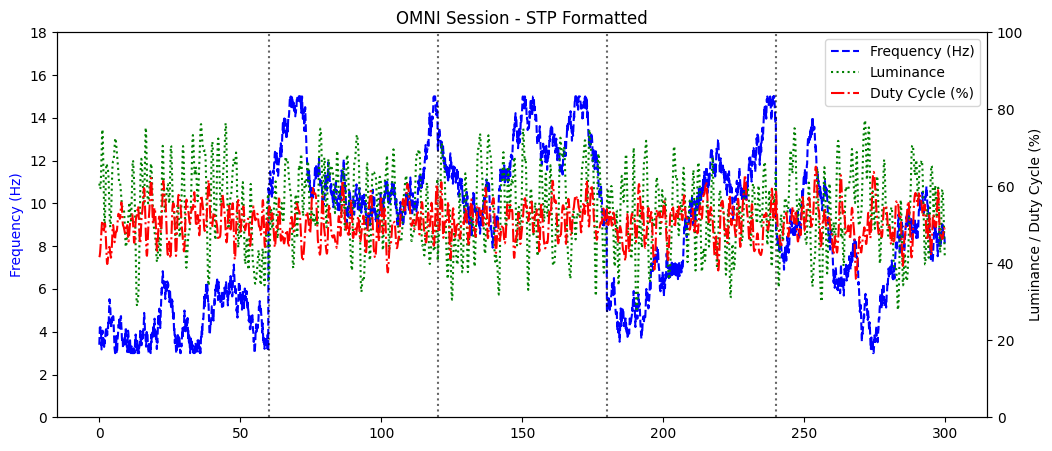

OMNI session generated, saved, and plotted successfully.


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# ===========================
# Load Session Data
# ===========================
session_types = ["HG", "OM", "DP", "CE", "RE"]
stp_dir = "stp_sessions"

# Load all session TXT files from stp_sessions/
sessions = {}

for name in session_types:
    session_path = f"{stp_dir}/{name}.txt"

    with open(session_path, "r", encoding="utf-8") as f:
        lines = f.readlines()[2:]  # Skip first two header lines (TIM and DUR)

    # Parse STP-formatted data
    data = []
    for line in lines:
        line = line.strip().replace('STP"', '')  # Remove "STP" prefix
        values = line.split(",")  # Split on commas

        # **Remove trailing quotes from last value**
        values = [v.strip().replace('"', '') for v in values]

        # Convert to float and store
        data.append([float(v) for v in values])

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=[
        "Step Duration", "Wave Type", "Start Freq", "End Freq",
        "Start Duty", "End Duty", "LED1", "LED2", "LED3", "LED4",
        "Start Lum", "End Lum"
    ])

    # Assign Time column based on cumulative duration
    df["Time (s)"] = np.arange(0, len(df) * 0.1, 0.1)[:len(df)]

    sessions[name] = df

# ===========================
# Generate OMNI Session (Segmented)
# ===========================

def generate_omni_session(sessions):
    """
    Creates an 'OMNI' session by sequentially combining 60-second chunks
    from each session type while preserving their unique variability.
    """
    session_segments = {
        "HG": (0, 60),
        "OM": (60, 120),
        "DP": (120, 180),
        "CE": (180, 240),
        "RE": (240, 300)
    }

    omni_chunks = []
    cumulative_time = 0  # Keeps track of total session time

    for mode, (start_time, end_time) in session_segments.items():
        df = sessions[mode]

        # Select rows that fall within the time range
        chunk = df[(df["Time (s)"] >= start_time) & (df["Time (s)"] < end_time)].copy()

        # Adjust time to be continuous
        chunk["Time (s)"] = np.arange(cumulative_time, cumulative_time + len(chunk) * 0.1, 0.1)[:len(chunk)]
        cumulative_time += 60  # Each segment contributes exactly 60 seconds

        omni_chunks.append(chunk)

    # Concatenate all chunks in order
    omni_df = pd.concat(omni_chunks, ignore_index=True)

    return omni_df

omni_session = generate_omni_session(sessions)

# ===========================
# Convert OMNI to STP Format
# ===========================

def format_strobe_sequence(df, wave_type):
    """Formats DataFrame into STP format while preserving interpolation & rounding values appropriately."""
    output = []
    session_duration = df["Time (s)"].max()
    output.append(f'TIM"00:00:{session_duration:.1f}"')
    output.append(f'DUR"{session_duration:.1f}"')

    for i in range(len(df) - 1):
        step_duration = 0.1  # Fixed step duration
        start_freq = df.loc[i, "Start Freq"]
        end_freq = df.loc[i + 1, "End Freq"]
        start_l = round(df.loc[i, "Start Lum"])  # **Round to whole number**
        end_l = round(df.loc[i + 1, "Start Lum"])  # **Round to whole number**
        start_d = round(df.loc[i, "Start Duty"])  # **Round to whole number**
        end_d = round(df.loc[i + 1, "Start Duty"])  # **Round to whole number**

        stp_line = (
            f'STP"{step_duration:.1f},{wave_type},'
            f'{start_freq:.2f},{end_freq:.2f},'
            f'{start_d},{end_d},'
            f'1,1,1,1,'  # All LEDs on
            f'{start_l},{end_l}"'
        )
        output.append(stp_line)

    return "\r\n".join(output)  # Use CRLF line endings

# Save OMNI session as TXT in STP format
wave_type = 1  # Default to Square wave for OMNI
strobe_data = format_strobe_sequence(omni_session, wave_type)
omni_filename = f"{stp_dir}/OMNI.txt"

with open(omni_filename, "w", encoding="utf-8") as f:
    f.write(strobe_data)

print(f"OMNI session saved: {omni_filename}")

# ===========================
# Plot OMNI Session
# ===========================
fig, ax = plt.subplots(figsize=(12, 5))
ax2 = ax.twinx()  # Create a second y-axis for Luminance & Duty Cycle

# Plot Frequency (Left Y-axis: 0-18 Hz)
ax.plot(omni_session["Time (s)"], omni_session["Start Freq"], linestyle="dashed", color="blue", label="Frequency (Hz)")
ax.set_ylim(0, 18)

# Plot Luminance and Duty Cycle (Right Y-axis: 0-100%)
ax2.plot(omni_session["Time (s)"], omni_session["Start Lum"], linestyle="dotted", color="green", label="Luminance")
ax2.plot(omni_session["Time (s)"], omni_session["Start Duty"], linestyle="dashdot", color="red", label="Duty Cycle (%)")
ax2.set_ylim(0, 100)

# Add vertical markers to show session transitions
for transition_time in [60, 120, 180, 240]:
    ax.axvline(x=transition_time, color="black", linestyle="dotted", alpha=0.6)

# Labels and Titles
ax.set_ylabel("Frequency (Hz)", color="blue")
ax2.set_ylabel("Luminance / Duty Cycle (%)", color="black")
ax.set_title("OMNI Session - STP Formatted")

# Legend handling
ax_lines, ax_labels = ax.get_legend_handles_labels()
ax2_lines, ax2_labels = ax2.get_legend_handles_labels()
ax2.legend(ax_lines + ax2_lines, ax_labels + ax2_labels, loc="upper right")

plt.xlabel("Time (s)")
plt.show()

print("OMNI session generated, saved, and plotted successfully.")